In [49]:
import pandas as pd
import statsmodels as sm
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use("../assets/plot_styles.mplstyle")
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from collections import Counter
import ast
import sys
import json
import redis
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import cv2
from bs4 import BeautifulSoup


sys.path.append('../library')
from core import flattenWithGenerator, createSlidingWindows, exceptionOutput
from midStats import linearModelGeneral
from plotting import loadPalette, loadTableStyles, createBoxplotWithTTests
from imageProcessing import *

from IPython.display import display, Markdown
from datetime import timedelta
import time
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as mcolors

from adjustText import adjust_text
from tabulate import tabulate
from tqdm.notebook import tqdm
import requests

colorPalette = loadPalette()

In [50]:
saveImagePath = '../assets/savedImages/whoIsTheBiggestMovieStarInTheWorld'

if not os.path.exists(saveImagePath):
    os.makedirs(saveImagePath)

TMDB_AUTH_TOKEN = os.getenv('TMDB_AUTH_TOKEN')

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {TMDB_AUTH_TOKEN}"
}

### Load credits from redis

In [51]:
r = redis.Redis(
    host='127.0.0.1',
    port=6379,
    charset="utf-8",
    decode_responses=True,
    db=6
)

keys = r.keys('*')
values = r.mget(keys)

creditsDict = []

for i,v in enumerate(tqdm(values)):
    vJ = json.loads(v)
    imdbId = {'imdbId':keys[i]}
    cast = [{**c, **imdbId} for c in vJ['cast']]
    creditsDict += cast
    

  0%|          | 0/540868 [00:00<?, ?it/s]

In [52]:
creditsDf = pd.DataFrame.from_dict(creditsDict)

### Load TMDB Df

In [53]:
tmdbDfRaw = pd.read_csv('../data/tmdbDetails.csv')
tmdbDfRaw.drop_duplicates('imdb_id', keep='last', inplace=True)
tmdbDfRaw = tmdbDfRaw[tmdbDfRaw['adult'] == False]
tmdbDfRaw = tmdbDfRaw[tmdbDfRaw['genres'].str.contains('Animation') == False]

In [54]:
allIds = list(tmdbDfRaw['imdb_id'].unique())

with open('../data/allIds.json', 'w') as f:
    json.dump(allIds, f)

### Filter TMDB for what we have credits on

In [83]:
def preprocessData(tmdbDf):
    """
    Turning this into a fn as we are going to be repeating these steps on some different versions of the df
    It isn't doing anything fancy, just a bunch of pandas business
    """
    tmdbDf = tmdbDf[tmdbDf['imdb_id'].isin(creditsDf['imdbId'].unique())]
    tmdbDf.drop_duplicates(subset=['imdb_id'], inplace=True, keep='last')
    tmdbDf = tmdbDf[tmdbDf['revenue'] > 0]
    tmdbDf = tmdbDf[tmdbDf['budget'] > 0]
    tmdbDf = tmdbDf[['imdb_id','release_date','revenue','budget']]
    tmdbDf.set_index('imdb_id', inplace=True, drop=True)
    tmdbDict = tmdbDf.to_dict('index')

    creditsDf['tmdbInfo'] = creditsDf['imdbId'].map(tmdbDict)
    expDf = pd.json_normalize(creditsDf['tmdbInfo'])
    resDf = creditsDf.drop(columns=['tmdbInfo']).join(expDf)
    resDf = resDf[resDf['known_for_department'] == 'Acting']
    resDf['contribution'] = resDf['revenue'] / (resDf['cast_id'] + 1) # indexing starts at 0

    idNameMap = resDf[['id','name']].set_index('id').to_dict()['name']

    totalSums = pd.DataFrame(resDf.groupby('id')[['revenue','contribution']].agg({'sum', 'size'}))
    totalSums.columns = ['_'.join(col).strip() for col in totalSums.columns.values]
    totalSums.sort_values(by='revenue_sum', ascending=False, inplace=True)
    totalSums.drop(columns='contribution_size', inplace=True)
    totalSums.rename(columns={'revenue_size':'size'}, inplace=True)
    totalSums['name'] = totalSums.index.map(idNameMap)

    # get headshots for outliers
    # Calculate Q1, Q3, and IQR
    Q3Y1 = totalSums['revenue_sum'].quantile(0.99995)
    Q3Y2 = totalSums['contribution_sum'].quantile(0.99995)

    outliersY1 = totalSums[totalSums['revenue_sum'] >= Q3Y1]
    outliersY2 = totalSums[totalSums['contribution_sum'] >= Q3Y2]

    # annotations = [p for p in list(outliersX.index) if p in outliersY.index.unique()]
    annotations = [list(outliersY1.index), list(outliersY2.index)]
    annotationsFlat = list(flattenWithGenerator(annotations))

    cutoff = 20

    print(f"NUMBER OF OUTLIERS = {len (annotationsFlat)}")
    print(f"ONLY PLOTTING {cutoff}")

    for annotation in tqdm(annotationsFlat[:cutoff]):
        getHeadshot(annotation, headers)

    for annotation in tqdm(annotationsFlat[:cutoff]):
        try:
            if len(os.listdir(f'../data/headshots/{annotation}')) == 0:
                continue
            filePath = f'../data/headshots/{annotation}/{annotation}_0.jpg'
            extractFaces(filePath, makePretty=True)
        except Exception as e:
            print(exceptionOutput(e))
            print(annotation)

    return totalSums, annotations, annotationsFlat, idNameMap

### Pulling headshots for people in our outliers
- We'll move this to an asyncio when pulling for all actors

In [84]:
totalSums, annotations, annotationsFlat, idNameMap = preprocessData(tmdbDfRaw)

NUMBER OF OUTLIERS = 260
ONLY PLOTTING 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

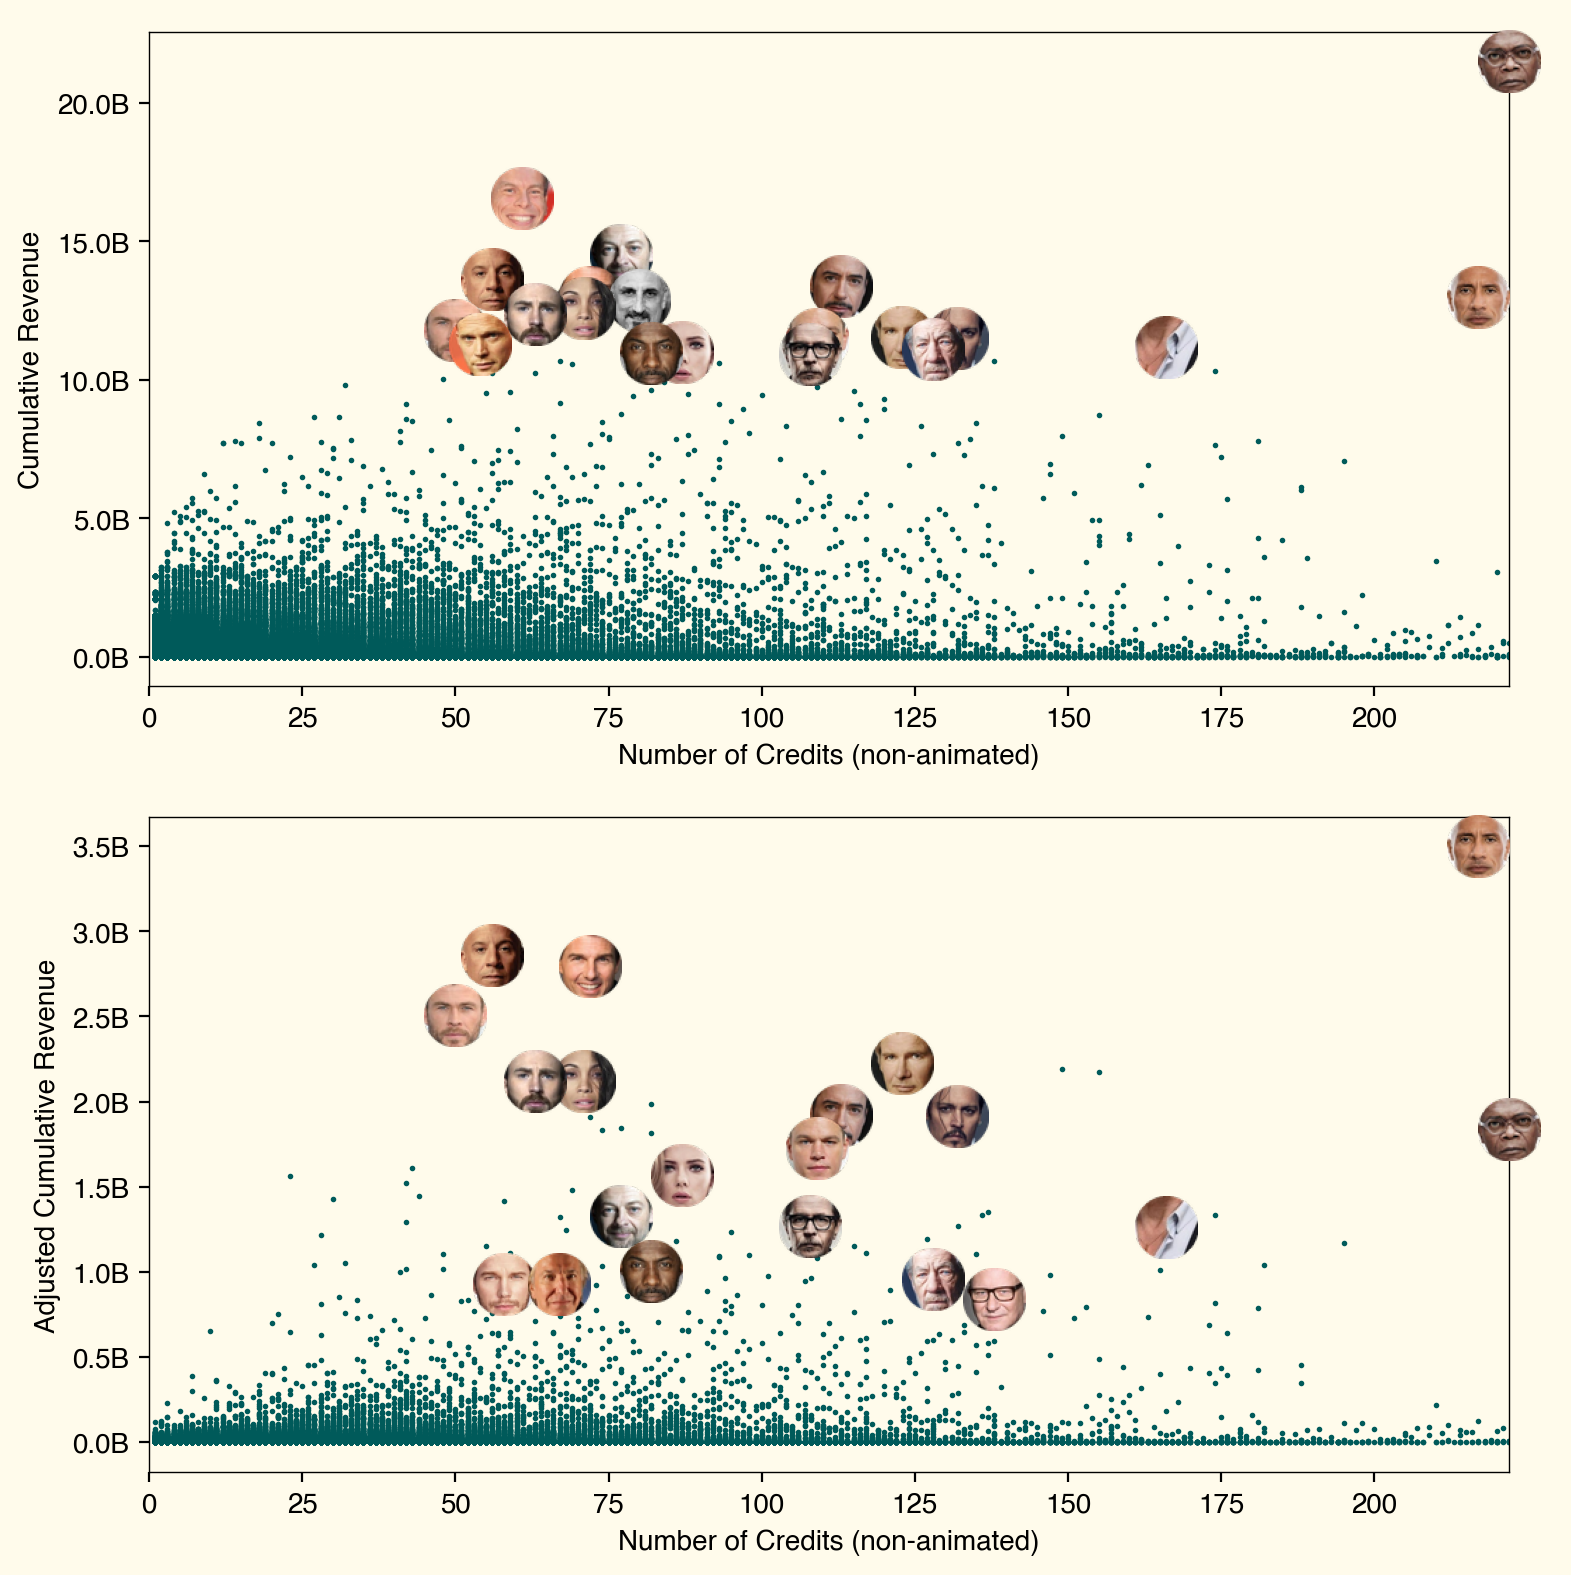

In [85]:
# Define formatter function
def billions(x, pos):
    return f'{x * 1e-9:.1f}B'

fig, axs = plt.subplots(2,1, figsize=(8,8))

for idx, targetCol in enumerate(['revenue_sum','contribution_sum']):
    ax = axs[idx]

    ax.scatter(totalSums['size'], totalSums[targetCol], c = loadPalette()['blue_grey_dark'])

    # Define line points
    x_vals = np.array(ax.get_xlim())
    y_vals = x_vals  # Slope of one

    # Plot line

    # Apply formatter to x and y axes
    formatter = FuncFormatter(billions)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel('Number of Credits (non-animated)')

    if idx == 0:
        ax.set_ylabel('Cumulative Revenue')
    else:
        ax.set_ylabel('Adjusted Cumulative Revenue')

    xLim = 0
    for annotation in annotations[idx][:20]:
        try:
            imgPath = f'../data/headshots/{annotation}/00_faceExtracted.png'
            annotationData = totalSums[totalSums.index == annotation]
            
            if annotationData['size'].iloc[0] > xLim:
                xLim = annotationData['size'].iloc[0]

            x, y = annotationData['size'].iloc[0], annotationData[targetCol].iloc[0]
            img = Image.open(imgPath)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
            img = img.resize((45, 45), Image.LANCZOS)  # Resize image with high-quality interpolation

            imagebox = OffsetImage(img, zoom=0.5)  # Adjust zoom to fit the resized image
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            pass

    ax.set_xlim(0, xLim)

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, hspace=0.2, wspace=0.15)


# Save image
imageFilePath = os.path.join(saveImagePath, 'outlierScatter.png')
plt.savefig(imageFilePath, dpi=300)

plt.show()

### Nice df showing rankings across three columns

In [86]:
totalSums = totalSums[totalSums['size'] > 20]

totalSums['perMovieRevAvg'] = totalSums['revenue_sum'] / totalSums['size']
totalSums['perMovieContAvg'] = totalSums['contribution_sum'] / totalSums['size']

totalSums.drop(columns='size', inplace=True)


rankDict = {}
for column in [c for c in totalSums.columns if c != 'name']:
    ranks = totalSums[['name',column]].sort_values(by=column, ascending = False)
    rankDict[column] = list(ranks['name'])[:20]

In [87]:
rankDf = pd.DataFrame.from_dict(rankDict)
rankDf.index.name = 'Rank'
rankDf.columns = ['Total Revenue','Total Revenue Adjusted','Avg. Revenue','Avg. Revenue Adjusted']

In [88]:
# Map Colors
uniqueValues = rankDf.values.ravel('K')
counts = Counter(uniqueValues)
min3 = [k for k,v in counts.items() if v > 2]
colors = list(loadPalette().values())[:len(min3)]
color_map = {val: f'background-color: {color}' for val, color in zip(min3, colors)}

# Apply colors
def highlightCells(val):
    return color_map.get(val, '')

styledDf = rankDf.style.applymap(highlightCells).set_table_styles(loadTableStyles())
display(Markdown(f"<h3 style='font-family:monospace; background-color:{loadPalette()['canvas_dark']}; color:black; padding:10px; margin-bottom:0;font-weight:bold;'>Revenue Rankings (minimum 20 credits)</h3>"))
display(styledDf)

<h3 style='font-family:monospace; background-color:#c9baa9; color:black; padding:10px; margin-bottom:0;font-weight:bold;'>Revenue Rankings (minimum 20 credits)</h3>

,Total Revenue,Total Revenue Adjusted,Avg. Revenue,Avg. Revenue Adjusted
Rank,,,,
0,Samuel L. Jackson,Dwayne Johnson,Kiran Shah,Chadwick Boseman
1,Warwick Davis,Vin Diesel,Pat Kiernan,Vin Diesel
2,Andy Serkis,Tom Cruise,Emma Watson,Chris Hemsworth
3,Vin Diesel,Chris Hemsworth,Florence Kasumba,Gal Gadot
4,Robert Downey Jr.,Harrison Ford,Lupita Nyong'o,Rupert Grint
5,Dwayne Johnson,Tom Hanks,Rupert Grint,Tom Cruise
6,Tom Cruise,Bruce Willis,Warwick Davis,Eddie Redmayne
7,Michael Papajohn,Zoe Saldaña,Paul Kasey,Wu Jing
8,Zoe Saldaña,Chris Evans,Spencer Wilding,Daniel Radcliffe


### Filter Out Franchises
- Note that the belongs_to_collection column is not perfect (e.g., "The Eternals" is missed)
- We'll do a secondary filter on production company perhaps...

In [89]:
standaloneDf = tmdbDfRaw[tmdbDfRaw['belongs_to_collection'] != tmdbDfRaw['belongs_to_collection']]

# Filter marvel
standaloneDf = standaloneDf[standaloneDf['production_companies'].str.contains('Marvel') == False]

# Filter Star Wars
standaloneDf = standaloneDf[standaloneDf['production_companies'].str.contains('Lucasfilm') == False]

standaloneDf.sort_values(by='revenue', ascending=False, inplace=True)

In [90]:
nonIPTotalSums, nonIPAnnotations, nonIPAnnotationsFlat, nonIPIdNameMap = preprocessData(standaloneDf)

NUMBER OF OUTLIERS = 260
ONLY PLOTTING 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

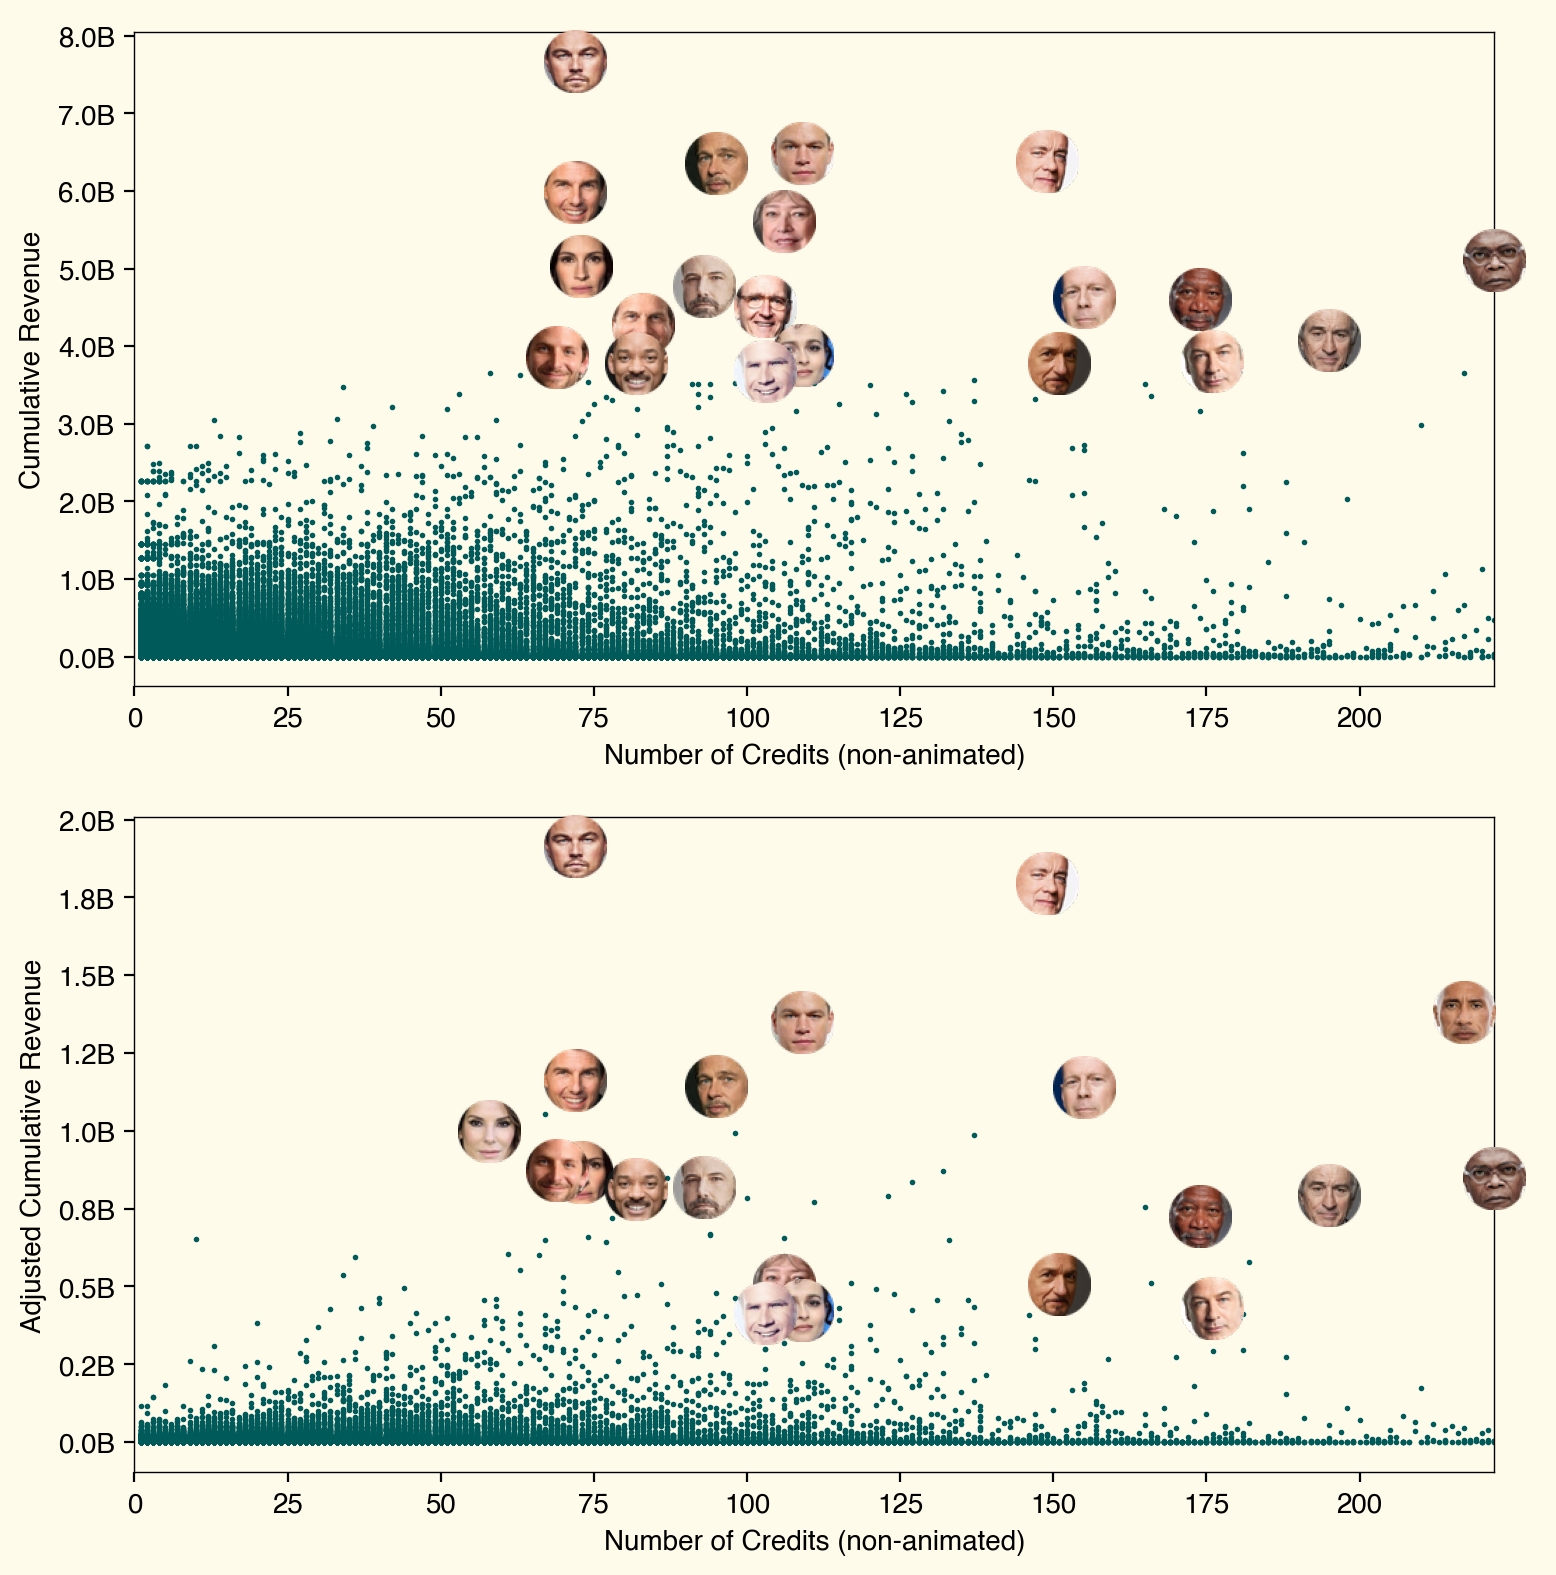

In [91]:
# Define formatter function
fig, axs = plt.subplots(2,1, figsize=(8,8))

for idx, targetCol in enumerate(['revenue_sum','contribution_sum']):
    ax = axs[idx]

    ax.scatter(nonIPTotalSums['size'], nonIPTotalSums[targetCol], c = loadPalette()['blue_grey_dark'])

    # Define line points
    x_vals = np.array(ax.get_xlim())
    y_vals = x_vals  # Slope of one

    # Plot line

    # Apply formatter to x and y axes
    formatter = FuncFormatter(billions)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel('Number of Credits (non-animated)')

    if idx == 0:
        ax.set_ylabel('Cumulative Revenue')
    else:
        ax.set_ylabel('Adjusted Cumulative Revenue')

    xLim = 0
    for annotation in nonIPAnnotations[idx][:20]:
        try:
            imgPath = f'../data/headshots/{annotation}/00_faceExtracted.png'
            annotationData = nonIPTotalSums[nonIPTotalSums.index == annotation]
            
            if annotationData['size'].iloc[0] > xLim:
                xLim = annotationData['size'].iloc[0]

            x, y = annotationData['size'].iloc[0], annotationData[targetCol].iloc[0]
            img = Image.open(imgPath)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
            img = img.resize((45, 45), Image.LANCZOS)  # Resize image with high-quality interpolation

            imagebox = OffsetImage(img, zoom=0.5)  # Adjust zoom to fit the resized image
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            pass

    ax.set_xlim(0, xLim)

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, hspace=0.2, wspace=0.15)


# Save image
imageFilePath = os.path.join(saveImagePath, 'outlierScatterNonFranchise.png')
plt.savefig(imageFilePath, dpi=300)

plt.show()

### Compare awards across the two groups of outliers

In [92]:
with open('../assets/actingAwards.html', 'r', encoding='utf-8') as file:
    htmlContent = file.read()

# Step 3: Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(htmlContent, 'html.parser')

In [93]:
subgroups = soup.find_all(class_='result-subgroup')
allTextBlob = ""
for subgroup in subgroups:
    internals = subgroup.find_all('div')
    links = []
    
    for div in internals:        
        nominationLink = div.find(class_='nominations-link')
        if nominationLink:
            linkText = nominationLink.get_text(strip=True)
            if linkText not in links:
                allTextBlob += linkText
                links.append(linkText)

In [94]:
IPAwards = {}
nonIPAwards = {}
for annotation in annotations[1]:
    name = idNameMap[annotation]

    IPAwards[annotation] = allTextBlob.count(name)

for annotation in nonIPAnnotations[1]:
    name = nonIPIdNameMap[annotation]

    nonIPAwards[annotation] = allTextBlob.count(name)

In [95]:
ipDf = pd.DataFrame.from_dict({'count':IPAwards})
ipDf['group'] = 'IP'
nonIpDf = pd.DataFrame.from_dict({'count':nonIPAwards})
nonIpDf['group'] = 'Non-IP'

tDf = pd.concat([ipDf, nonIpDf], axis=0)

Text(1.5, 21, 't-stat: -1.28\np-value: 0.201')

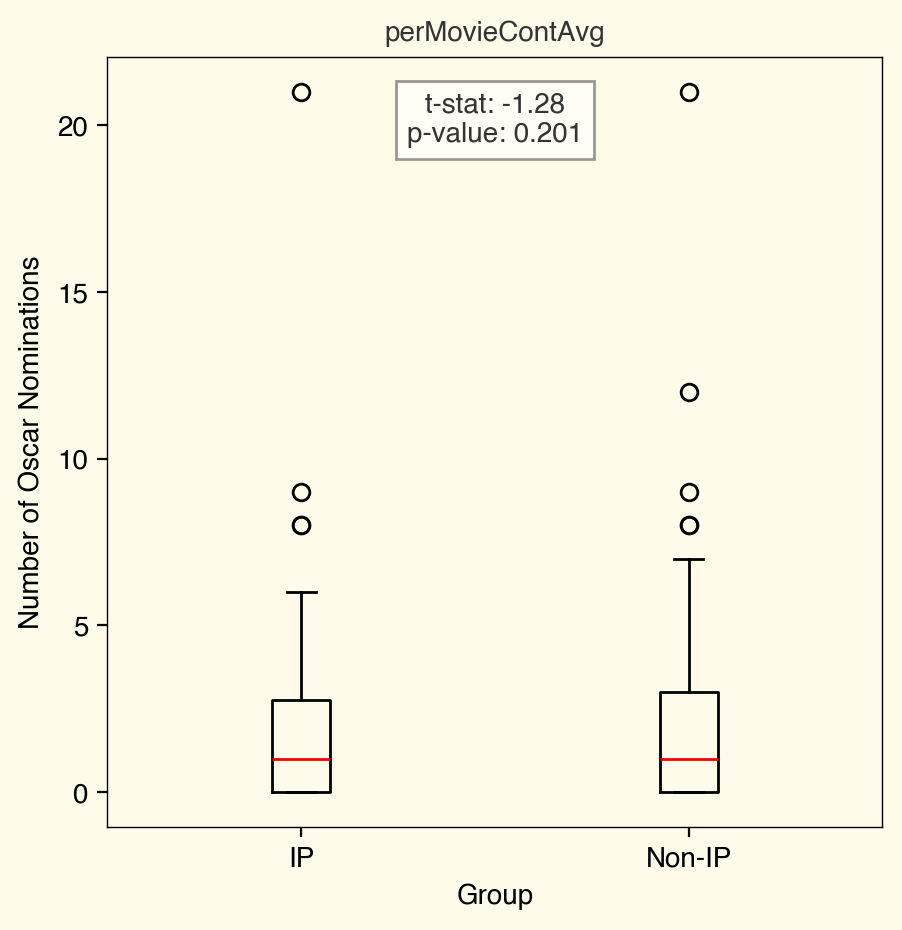

In [96]:
from scipy import stats
fig, ax = plt.subplots(figsize=(5,5))
group_a = tDf[tDf['group'] == 'IP']['count']
group_b = tDf[tDf['group'] == 'Non-IP']['count']

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_a, group_b)

# Create boxplot
ax.boxplot([group_a, group_b], labels=['IP','Non-IP'])
ax.set_title(f'{column}')
ax.set_xlabel('Group')
ax.set_ylabel('Number of Oscar Nominations')

# Overlay t-test results
ax.text(1.5, max(group_a.max(), group_b.max()), f't-stat: {t_stat:.2f}\np-value: {p_value:.3f}', 
    horizontalalignment='center', verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))